In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nemesispy.common.info_mol_id import mol_id
from nemesispy.common.constants import *
import os
from nemesispy.radtran.forward_model import ForwardModel
from nemesispy.radtran.calc_mmw import calc_mmw
import pyfastchem
from nemesispy.common.constants import ATM, G, AU, R_SUN, R_EAR_E, M_EAR, K_B, N_A, AMU
from nemesispy.common.info_mol_id import mol_id
from nemesispy.models.gas_profiles import gen_vmr
from nemesispy.models.TP_profiles import TP_madhu
from nemesispy.common.calc_hydrostat import calc_hydrostat
import spectres
import sys

K_B_cgs = K_B * 1e7

In [2]:
__projdir__ = os.environ['projdir']
fastchem_path = os.path.join(__projdir__, "runs/fastchem_try/FastChem")
f1_path = os.path.join(fastchem_path, "input/element_abundances/asplund_2020_P.dat")
f2_path = os.path.join(fastchem_path, "input/logK/logK.dat")
fastchem = pyfastchem.FastChem(f1_path, f2_path,0)
solar_abundances = np.array(fastchem.getElementAbundances())

Stoichiometry of species Al1Cl1 incomplete. Neglected!
Stoichiometry of species Al1Cl1F1 incomplete. Neglected!
Stoichiometry of species Al1Cl1F2 incomplete. Neglected!
Stoichiometry of species Al1Cl1O1 incomplete. Neglected!
Stoichiometry of species Al1Cl2 incomplete. Neglected!
Stoichiometry of species Al1Cl2F1 incomplete. Neglected!
Stoichiometry of species Al1Cl3 incomplete. Neglected!
Stoichiometry of species Al1F1 incomplete. Neglected!
Stoichiometry of species Al1F1O1 incomplete. Neglected!
Stoichiometry of species Al1F2 incomplete. Neglected!
Stoichiometry of species Al1F2O1 incomplete. Neglected!
Stoichiometry of species Al1F3 incomplete. Neglected!
Stoichiometry of species Al1F4Na1 incomplete. Neglected!
Stoichiometry of species Al1H1 incomplete. Neglected!
Stoichiometry of species Al1H1O1_1 incomplete. Neglected!
Stoichiometry of species Al1H1O1_2 incomplete. Neglected!
Stoichiometry of species Al1H1O2 incomplete. Neglected!
Stoichiometry of species Al1N1 incomplete. Neglect

# Loading

In [3]:
# prf_header = ['height', 'press', 'temp', 'h2o', 'co2', 'co', 'ch4', 'h2', 'he', 'na', 'k']
# prf = pd.read_csv('./example_data/hd189.prf', skiprows=11, header=None, sep='\s+')
# prf.columns = prf_header
# print(prf.head())
# H_model = prf['height'].values * 1e3
# P_model = prf['press'].values * ATM
# T_model = prf['temp'].values
# VMR_model = prf[['h2o', 'co2', 'co', 'ch4','na','k', 'h2', 'he']].values
# NLAYER = len(P_model) # Number of layers
planet_spec = pd.read_csv('./example_data/hd189_data.txt', header=None, sep='\s+')
planet_wave = planet_spec[0].values
spec = planet_spec[1].values
spec_err = planet_spec[2].values

st_spec = pd.read_csv('./example_data/hd189.dat', skiprows=3, header=None, sep='\s+')
st_wave_full = st_spec[0].values
st_flux_full = st_spec[1].values / (4*np.pi) # Check this!
st_wave = planet_wave.copy()
flux_star = spectres.spectres(planet_wave, st_wave_full, st_flux_full)
# plt.gca().set_xscale('log')

#### Loading in .ref/.prf file

Add whatever columns you need

['H2O', 'CO2', 'H2', 'He']


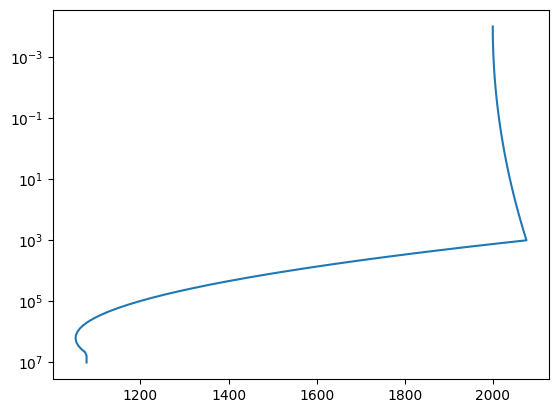

In [14]:
# df = pd.read_csv('LTT9779b_data.csv')
# wv = df['wave']
# wv_err = df['wave_err']
# spec = df['dppm']
# spec_err = df['dppm_err']

# LTT 9779b parameters (Jenkins 2020)
R_star = 0.949 * R_SUN
SMA = 0.01679 * AU
T_star = 5443.0
T_int = 200.0 # check?
M_plt = 29.32 * M_EAR
R_plt = 4.72 * R_EAR_E
g_plt = G * M_plt / R_plt**2

n_plevels = 100
NLAYER = n_plevels
P = np.logspace(2, -9, n_plevels) * ATM
P_model = P

# ktable_list = 'LTT9779b_jake_R100' # wavelength bin to required dataset
ktable_list = 'hd189_refl' # wavelength bin to required dataset
gas_names_active = ['H2O', 'CO2']
gas_names_inactive = ['H2', 'He']
param_names_nongas=['P1','P2','P3','T0','alpha1','alpha2','deep','Pbase','FSH','prad','pwidth']

plot_species = ['H2O1', 'C1O2', 'H2', 'He']
                # 'C1O2', 'C1O1', 'H3N1', 'H3P1', \
                # 'C1H4', 'O2S1', 'H2S1', 'C2H2', 'N2', 'H2', 'He']
plot_species_labels = gas_names_active + gas_names_inactive
plot_species_indices = []
plot_species_symbols = []

for i, species in enumerate(plot_species):
  index = fastchem.getGasSpeciesIndex(species)
  if index != pyfastchem.FASTCHEM_UNKNOWN_SPECIES:
    plot_species_indices.append(index)
    plot_species_symbols.append(plot_species_labels[i])
  else:
    print("Species", species, "to plot not found in FastChem")

print(plot_species_symbols)

gas_id = [mol_id[gas] for gas in gas_names_active] + [mol_id[gas] for gas in gas_names_inactive]
nvmr = len(gas_names_active)
n_params = nvmr + len(param_names_nongas)

# Setup
gas_id = np.array(gas_id)
iso_id = np.zeros_like(gas_id)
# __location__ = os.environ['nemesispy_dir']
__location__ = '.'
ktable_path = os.path.join(__location__, "nemesispy/data/ktables")
lowres_file_paths = [f'{gas}_{ktable_list}.kta' for gas in gas_names_active]
for ipath,path in enumerate(lowres_file_paths):
    lowres_file_paths[ipath] = os.path.join(ktable_path,path)
cia_folder_path = os.path.join(__location__ , "nemesispy/data/cia")
cia_file_path = os.path.join(cia_folder_path,'exocia_hitran12_200-3800K.tab')

FM = ForwardModel()
FM.set_opacity_data(kta_file_paths=lowres_file_paths, cia_file_path=cia_file_path)
FM.set_planet_model(
    M_plt=M_plt,R_plt=R_plt,
    gas_id_list=gas_id,iso_id_list=iso_id,
    NLAYER=NLAYER
    )
wave_grid = FM.wave_grid

param_dict = {} # param_name : index
for i,param in enumerate(gas_names_active + param_names_nongas):
    param_dict[param] = i

T = TP_madhu(P, -2.0, 1.2, 1.7, 2000.0, 0.8, 0.1)
plt.plot(T, P)
plt.gca().invert_yaxis()
plt.gca().set_yscale('log')
plt.show()

# Forward model analysis

We want to vary metallicity, a cloud parameterisation, and what the cloud is comprised of. 

In [5]:
def met_CO_to_VMR(metallicity, CO_ratio, T):
    # Link this to a chemical model, or something else
    # metallicity = 10.0 ** metallicity
    vmr = np.zeros((NLAYER, len(plot_species_symbols)))

    element_abundances = np.copy(solar_abundances)
    # h_abun = element_abundances[fastchem.getElementIndex('H')]
    for j in range(0, fastchem.getElementNumber()):
        if fastchem.getElementSymbol(j) != 'H' and fastchem.getElementSymbol(j) != 'He':
            element_abundances[j] = metallicity * element_abundances[j]

    element_abundances[fastchem.getElementIndex('C')] = CO_ratio * element_abundances[fastchem.getElementIndex('O')]
    fastchem.setElementAbundances(element_abundances)
    input_data = pyfastchem.FastChemInput()
    output_data = pyfastchem.FastChemOutput()
    input_data.pressure = P / 1e5 # Pa -> bar Noooo divide by 1e5 not multiply!!!!!
    input_data.temperature = T
    fastchem_flag = fastchem.calcDensities(input_data, output_data)
    gas_number_density = P * 10.0 / (K_B_cgs * T) # Pa->barye(cgs)
    number_densities = np.array(output_data.number_densities)

    for i in range(0, len(plot_species_symbols)):
        vmr[:, i] = number_densities[:, plot_species_indices[i]]/gas_number_density

    for k in range(NLAYER):
        if np.sum(vmr[k, :]) < 0.9:
            print(f"Sum of VMR for layer {k+1} = {np.sum(vmr[k, :])} < 0.9")
            # return np.nan # if gases not included exceed 20%
        vmr[k, :] = vmr[k, :] / np.sum(vmr[k, :])
    return vmr

Next up is the cloud parameterisation. We'll do something like model 9 in NEMESIS. This is very rough and was written quickly, so you might want to check it/write your own. In particular, the opacity will probably be quite off. But I'm assuming you want to use an optically thick cloud in which case you can just set it high.

In [6]:
from scipy.integrate import simpson

def cloud_top_pressure_to_A(VMR_model, H_model, T_model,
                            cloud_top_pressure, 
                            opacity = 10.0,
                            fsh = 1.0):
    
    A_model = np.zeros_like(P_model)
    
    cloud_top_height = np.interp(np.log(cloud_top_pressure),np.log(P_model[::-1]),H_model[::-1])
    
    
    
    grav = G*M_plt/((R_plt+H_model)**2)
    molwt = calc_mmw(gas_id, VMR_model.T)    
    
    scale = K_B* T_model / (molwt * grav)

    for i in np.where(H_model > cloud_top_height)[0]:
        if A_model[i-1] == 0:
            A_model[i] = 1
            continue

        A_model[i] = A_model[i-1] * np.exp(-(H_model[i] - H_model[i-1])/(scale[i]*fsh))
    A_model = A_model*(opacity/simpson(A_model,x=H_model))*1e4
        
    #A_model has to be shape (NLAYER,NMODES)
    A_model = A_model[:,None]
    return A_model

Now let's write a function that takes a path to a text file containing the real and imaginary refractive index spectrum for some aerosol.

In [7]:
def aerosol_path_to_forward_model(path, forward_model,
                                 mean_size = 0.05,
                                 size_variance = 0.05):
    
    aerosol = pd.read_csv(path, skiprows=2, header=None, sep='\s+')
    
    wave = aerosol[0].values
    n_real = aerosol[1].values
    n_imag = aerosol[2].values
    
    # Setting up phase function
    
    forward_model.clear_phase_function()
    
    n_imag_wave_grid = wave

    n_imag =  n_imag
    n_real = n_real

    forward_model.add_phase_function(mean_size = mean_size, 
                          size_variance = size_variance, 
                          n_imag = n_imag, 
                          n_imag_wave_grid = n_imag_wave_grid, 
                          n_real_reference = n_real,
                          n_real_reference_wave= wave_grid.min(),
                          iscat = 1)
    return forward_model

Let's test this and see what it looks like.

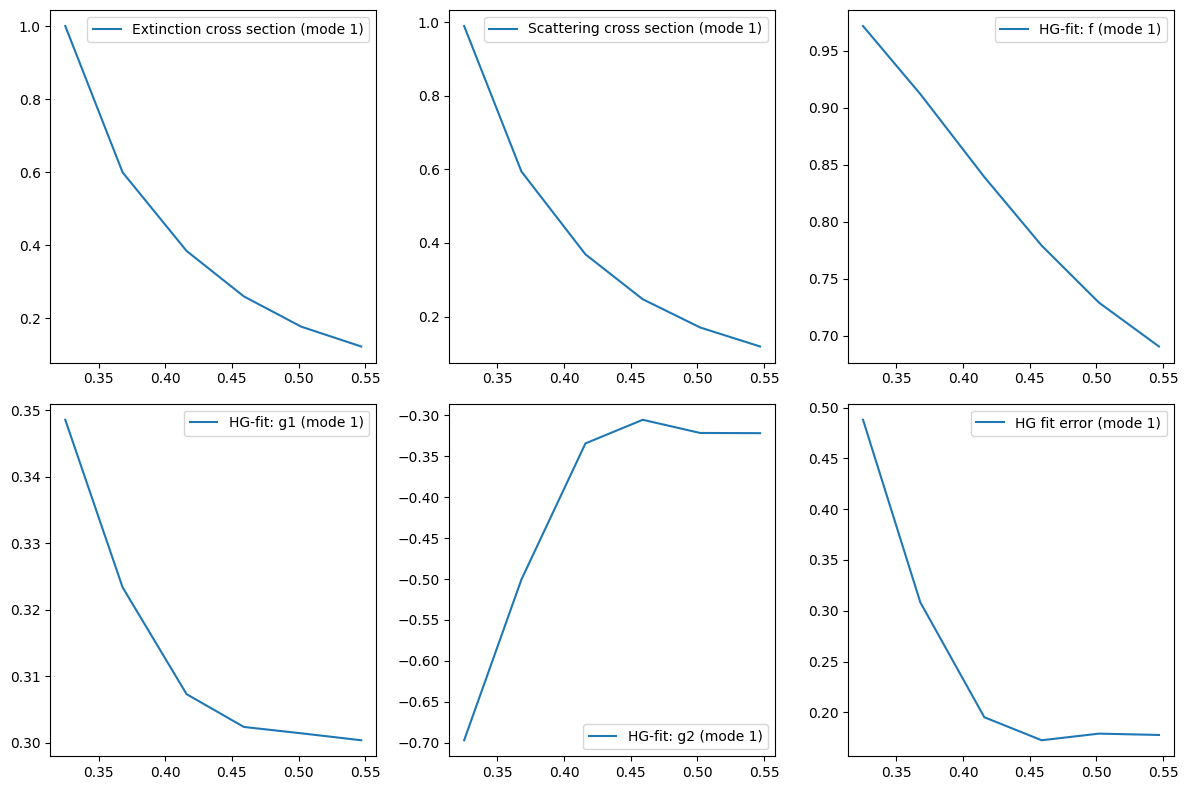

In [8]:
FM = aerosol_path_to_forward_model('./example_data/enstatite.dat',FM)

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
parameters = ['Extinction cross section','Scattering cross section',
              'HG-fit: f','HG-fit: g1','HG-fit: g2','HG fit error']
for i in range(6):
    row = i // 3
    col = i % 3
    axs[row, col].plot(FM.wave_grid, FM.phase_func[:, :, i].transpose())
    axs[row, col].legend([f'{parameters[i]} (mode 1)', f'{parameters[i]} (mode 2)'])

plt.tight_layout()
plt.show()

One iteration just to check the spectrum

Sum of VMR for layer 50 = 0.8968465344996346 < 0.9
Sum of VMR for layer 51 = 0.8851075652112335 < 0.9
Sum of VMR for layer 52 = 0.8721109129366514 < 0.9
Sum of VMR for layer 53 = 0.8577476439229734 < 0.9
Sum of VMR for layer 54 = 0.8419068303056195 < 0.9
Sum of VMR for layer 55 = 0.8244779449013901 < 0.9
Sum of VMR for layer 56 = 0.8053540527559664 < 0.9
Sum of VMR for layer 57 = 0.7844359399034527 < 0.9
Sum of VMR for layer 58 = 0.7616373110740231 < 0.9
Sum of VMR for layer 59 = 0.7368911585291158 < 0.9
Sum of VMR for layer 60 = 0.7101573433787661 < 0.9
Sum of VMR for layer 61 = 0.6814313258862735 < 0.9
Sum of VMR for layer 62 = 0.6507538185311142 < 0.9
Sum of VMR for layer 63 = 0.6182209030573483 < 0.9
Sum of VMR for layer 64 = 0.5839938462825425 < 0.9
Sum of VMR for layer 65 = 0.5483074824655727 < 0.9
Sum of VMR for layer 66 = 0.5114756467496047 < 0.9
Sum of VMR for layer 67 = 0.4738918339569631 < 0.9
Sum of VMR for layer 68 = 0.4360231618031336 < 0.9
Sum of VMR for layer 69 = 0.398

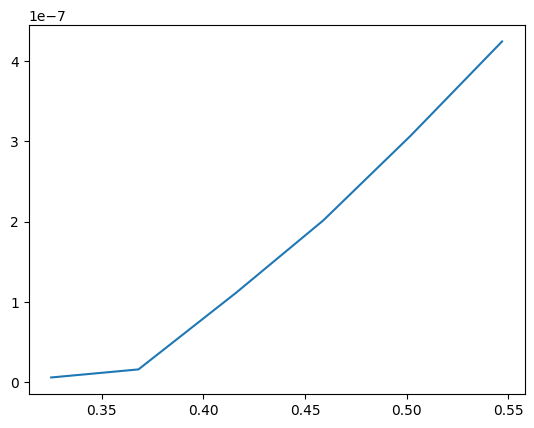

In [17]:
phase_angle = 0
co_ratio = 0.5
metallicity = 1.0
cloud_top_pressure = 10.0 ** -1.0 * ATM
aerosol_path = './example_data/enstatite.dat'
FM = aerosol_path_to_forward_model(aerosol_path,FM)

adjusted_VMR_model = met_CO_to_VMR(metallicity, co_ratio, T)
mmw = np.zeros(NLAYER)
for ipro in range(NLAYER):
    mmw[ipro] = calc_mmw(gas_id, adjusted_VMR_model[ipro,:])

H_model = calc_hydrostat(P=P, T=T, mmw=mmw,
        M_plt=M_plt, R_plt=R_plt)

# print(H_model)

A_model = cloud_top_pressure_to_A(adjusted_VMR_model, H_model, T, cloud_top_pressure)

spec_out = FM.calc_disc_spectrum_uniform(phase = phase_angle,
                                nmu = 5,
                                P_model = P_model,
                                T_model = T,
                                VMR_model = adjusted_VMR_model,
                                solspec = flux_star,
                                A_model = A_model
                            )
plt.plot(wave_grid, spec_out)
plt.show()
    

Now we can run our forward model analysis. You might want to parallelise over one of the loops if it's taking too long. It will take a minute or so to start running for the first time.

In [15]:
phase_angle = 0
co_ratio = 0.5
n_steps = 1
metallicities = 10**np.linspace(0,3,n_steps)
cloud_top_pressures = 10**np.linspace(2,-3,n_steps) * ATM
aerosol_paths = ['./example_data/enstatite.dat']

print(f"Min, Max metallicity: {metallicities.min(),metallicities.max()}")
print(f"Min, Max cloud top pressures (bar): {cloud_top_pressures.min()/ATM,cloud_top_pressures.max()/ATM}")
      

chisq_grid = np.zeros(((len(aerosol_paths),len(metallicities),len(cloud_top_pressures))))

for iap, ap in enumerate(aerosol_paths):
    
    FM = aerosol_path_to_forward_model(ap,FM)
    
    for im, m in enumerate(metallicities):
        
        adjusted_VMR_model = met_CO_to_VMR(m, co_ratio, T)
        mmw = np.zeros(NLAYER)
        for ipro in range(NLAYER):
            mmw[ipro] = calc_mmw(gas_id, adjusted_VMR_model[ipro,:])
        
        H_model = calc_hydrostat(P=P, T=T, mmw=mmw,
                M_plt=M_plt, R_plt=R_plt)
        
        # print(H_model)
        
        for ictp, ctp in enumerate(cloud_top_pressures):

            A_model = cloud_top_pressure_to_A(adjusted_VMR_model, H_model, T, ctp)

            spec_out = FM.calc_disc_spectrum_uniform(phase = phase_angle,
                                          nmu = 5,
                                          P_model = P_model,
                                          T_model = T,
                                          VMR_model = adjusted_VMR_model,
                                          solspec = flux_star,
                                          A_model = A_model
                                  )
            chisq = ((spec_out - spec)**2/spec_err**2).mean()
            chisq_grid[iap,im,ictp] = chisq      
            
            output = f"Chisq: {chisq:.2f}, Metallicity: {m:.2e}, Cloud top pressure (bar): {ctp/101325:.2e}, Path: {ap}, Spectrum: {ictp+im*n_steps+iap*n_steps*n_steps+1}/{chisq_grid.size}"
            sys.stdout.write(f"\r{output.ljust(800)}") 
            sys.stdout.flush()


Min, Max metallicity: (1.0, 1.0)
Min, Max cloud top pressures (bar): (100.0, 100.0)
Sum of VMR for layer 50 = 0.8968465344996346 < 0.9
Sum of VMR for layer 51 = 0.8851075652112335 < 0.9
Sum of VMR for layer 52 = 0.8721109129366514 < 0.9
Sum of VMR for layer 53 = 0.8577476439229734 < 0.9
Sum of VMR for layer 54 = 0.8419068303056195 < 0.9
Sum of VMR for layer 55 = 0.8244779449013901 < 0.9
Sum of VMR for layer 56 = 0.8053540527559664 < 0.9
Sum of VMR for layer 57 = 0.7844359399034527 < 0.9
Sum of VMR for layer 58 = 0.7616373110740231 < 0.9
Sum of VMR for layer 59 = 0.7368911585291158 < 0.9
Sum of VMR for layer 60 = 0.7101573433787661 < 0.9
Sum of VMR for layer 61 = 0.6814313258862735 < 0.9
Sum of VMR for layer 62 = 0.6507538185311142 < 0.9
Sum of VMR for layer 63 = 0.6182209030573483 < 0.9
Sum of VMR for layer 64 = 0.5839938462825425 < 0.9
Sum of VMR for layer 65 = 0.5483074824655727 < 0.9
Sum of VMR for layer 66 = 0.5114756467496047 < 0.9
Sum of VMR for layer 67 = 0.4738918339569631 < 0.

/STEM/data/project/users/ab39556/runs/nemesispy_scatter/nemesispy_agni/nemesispy/radtran/calc_radiance.py:675: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  spec_w_g[:,ig] = calc_spectrum_scloud11(wave_grid, phase_func,radground,


Chisq: 1.64, Metallicity: 1.00e+00, Cloud top pressure (bar): 1.00e+02, Path: ./example_data/enstatite.dat, Spectrum: 1/1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

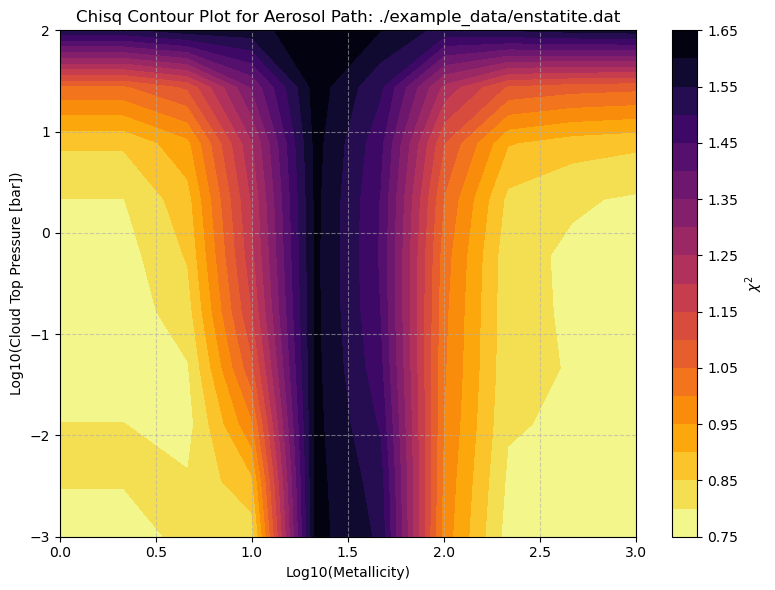

In [ ]:
for iap, ap in enumerate(aerosol_paths):
    X, Y = np.meshgrid(np.log10(metallicities), np.log10(cloud_top_pressures / 101325)) 
    Z = chisq_grid[iap]

    plt.figure(figsize=(8, 6))
    contour = plt.contourf(X, Y, Z, levels=20, cmap='inferno_r')
    plt.colorbar(contour, label=r'$\chi^2$')

    plt.title(f'Chisq Contour Plot for Aerosol Path: {ap}')
    plt.xlabel('Log10(Metallicity)')
    plt.ylabel('Log10(Cloud Top Pressure [bar])')
    plt.grid(True, which='both', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()